## Tomogram Particle Picking with Topaz3D

This notebook demonstrates 3D particle picking of cryo-ET tomograms in Topaz.

### Installing the Topaz3D Branch

__Topaz is assumed to be installed in a conda environment named "topaz3d" for purposes of running topaz commands within bash cells.__ If topaz was installed in some other way, then the "source activate topaz3d" lines will need to be removed or changed below.

You may need to install ipykernel to run the cells in this notebook. You can alternatively paste the commands into the command line.

In [ ]:
%%bash

# create and activate the relevant conda environment
# conda create -n topaz3d python=3.11
# conda activate topaz3d

# follow the instructions to install topaz from source
git clone https://github.com/tbepler/topaz
cd topaz

# checkout the branch you want to work on
git checkout dev-topaz3d
pip install .

# If that all works, then you should be able to run topaz train3d --help
topaz train3d --help

### Downloading the Demo Dataset

This dataset consists of 4 of the 7 tomograms made available for the Chan-Zuckerberg Imaging Institute CryoET Object Identification Kaggle challenge, and the associated ribosome annotations. Other particles are present in the mixture, but are ignored. Download using awscli:

```
mkdir ./3D-tutorial
cd ./3D-tutorial
aws s3 sync s3://topaz3d-tutorial-data/ ./
```

## Topaz3D Pipeline

The Topaz3D pipeline is by-and-large the same as for 2D particle picking. Users may refer to tutorials 01_quick_start_guide and 02_walkthrough for more in-depth explanations. At a high level, the pipeline consists of preparing preprocessing input tomograms and coordinates, training a model, and extracting predicted scores and particle positions.

There are currently no pretrained 3D particle picking models available, so all users should begin by using `topaz train3d` to train a model on their dataset.


## 1. Preprocessing

If necessary, we can downsample and normalize the given tomograms and coordinates. The provided tomograms are already normalized and at a reasonable resolution (10A/px), so we will bypass this step.

In [ ]:
# The original topaz preprocessing commands are not yet 3D compatible, so you can use the below code to normalize your images

# from glob import glob
# import pandas as pd
# from topaz.mrc import write
# from topaz.utils.data.loader import load_image

# imgs = glob('path/to/mrcs/*.mrc')
# for path in imgs:
#     img,header,_ = load_image(path, make_image=False)
#     # normalize image and update header
#     img = (img - img.mean()) / img.std()
#     header = header._replace(amin=img.min(), amax=img.max(), amean=img.mean(), rms=img.std())
#     # write to new file
#     destination = path.replace('path/to/mrcs', 'path/to/mrcs/normed/')
#     with open(destination, 'wb') as f:
#         write(f, img, header)

In [ ]:
# You can also scale your coordinates, if necessary

# scale = 1.0
# coordinates = pd.read_csv('path/to/coordinates.txt', sep='\t')
# coordinates[['x_coord', 'y_coord', 'z_coord']] = coordinates[['x_coord', 'y_coord', 'z_coord']] * scale
# coordinates.to_csv('new/path/to/coordinates.txt', sep='\t', index=False)

# 2. Model training

We now train the particle detection model using positive-unlabeled learning. We set the expected number of particles per micrograph here to 46.

In [ ]:
%%bash
#source activate topaz3d

cd 3D-tutorial

# first, make sure we have the folders where we want to put the saved models
# store the saved models in saved_models/
mkdir -p ./saved_models

# Now, we train the model

# We set -n 60 to tell Topaz that we expect there to be on average of 60 particles per micrograph

# By default, topaz train will use your first GPU if available, to force topaz train to use the CPU, set: -d -1
# To use a different GPU, set -d X where X is the GPU ID

# we reduce the number and size epochs here to speed up training, but you should increase these for your data (e.g. to the defaults)

topaz train3d --train-images train-mrcs --train-targets train_coordinates.txt \
    --test-images test-mrcs --test-targets test_coordinates.txt -n 60 \
        --save-prefix=./saved_models/ -o training_output.txt --epoch-size 5 --num-epochs 2

In [ ]:
# we can examine the training output to see how well the model is doing
!head -n 1 3D-tutorial/training_output.txt
!cat 3D-tutorial/training_output.txt | grep test

# 3. Extract particle coordinates

Now that we have a trained model, we use it to extract predicted particle coordinates using a particle radius of 14 pixels (this should be larger than the radius specified during training).

Extract can be run using a particle picking model trained above by passing the model path as an argument.

In [ ]:
%%bash
# source activate topaz

cd 3D-tutorial

## extract particle coordinates using the  trained model
## we set the radius parameter to 14 (-r 14) to prevent extracting particle coordinates closer than the radius of the particle
## i.e. we don't want multiple predictions for a single particle
## -p controls the patch size and should be as large as possible without exceeding the GPU memory

topaz extract --dims 3 -m saved_models/_epoch2.sav -r 14 -p 128 -o extracted_particles.txt -v -d 0 test-mrcs/*

# 4. Visualize picked particles

In [1]:
from topaz.utils.data.loader import load_image
import pandas as pd
import matplotlib.pyplot as plt # you might need to install this

# read the test image and labels
test_image, header, _ = load_image('./3D-tutorial/test-mrcs/TS_6_6.mrc', make_image=False)
test_labels = pd.read_csv('./3D-tutorial/test_coordinates.txt', sep='\t')

# read the predicted particles
particles = pd.read_csv('./3D-tutorial/extracted_particles.txt', sep='\t')

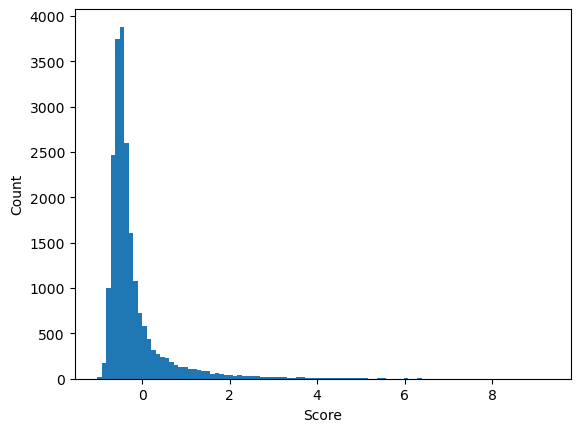

In [24]:
# look at the histogram of scores and threshold the picks
plt.hist(particles['score'], bins=100)
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

# threshold the picks
threshold = 1
thresholded_particles = particles[particles['score'] > threshold]

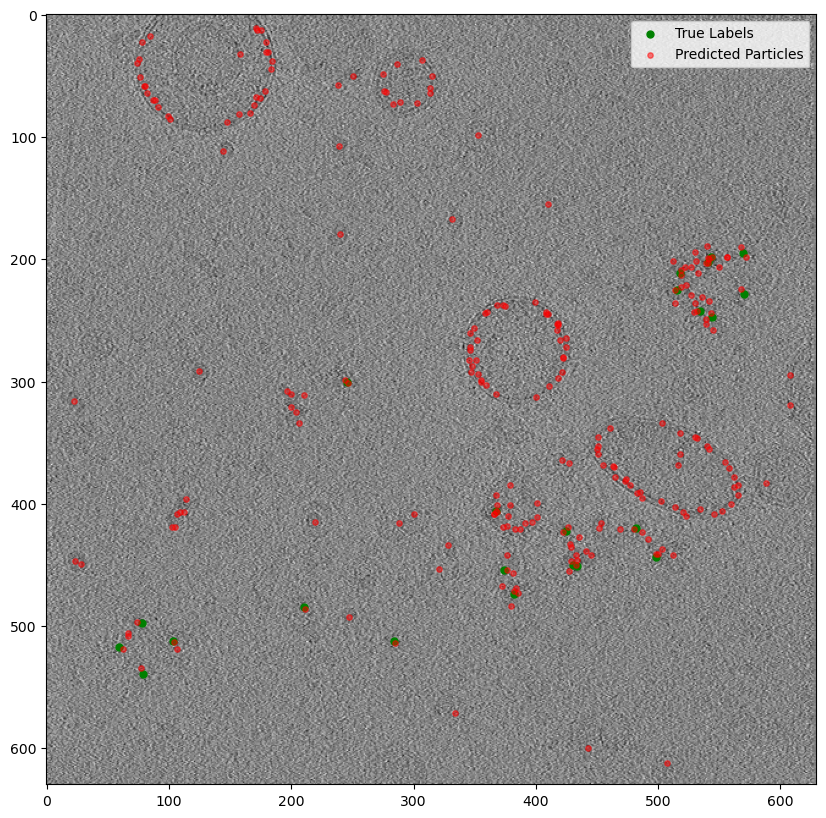

In [33]:
# plot the image, labels, and the predicted particles
plt.figure(figsize=(10, 10))
plt.imshow(test_image.mean(axis=0), cmap='gray')

plt.scatter(test_labels['x_coord'], test_labels['y_coord'], c='g', label='True Labels', s=25)
plt.scatter(thresholded_particles['x_coord'], thresholded_particles['y_coord'], c='r', label='Predicted Particles', s=15, alpha=0.5)
plt.legend()
plt.show()